# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Импорт, загрузка датасета, обзор данных:

### Импортируем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np

warnings.filterwarnings('ignore')

### Импортируем датасет

In [2]:
data = pd.read_csv('real_estate_data.csv', sep='\t')

### Первичный обзор информации и графиков:

In [3]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment             object
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

In [5]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

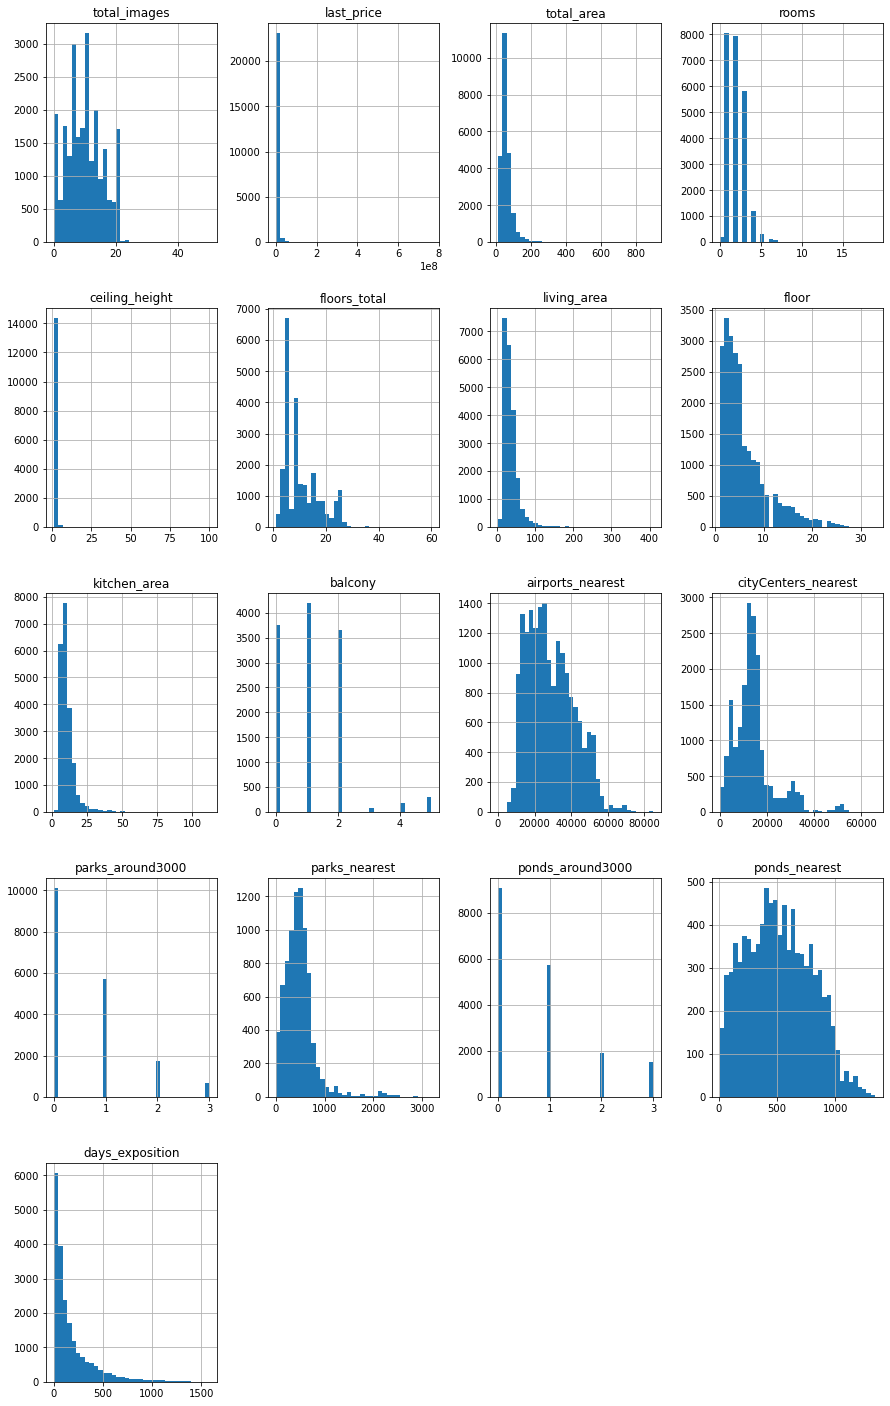

In [6]:
data.hist(bins=35, figsize=(15, 25));

**Выводы:**

1. Датасет имеет размер 23699 * 22. Типы данных не везде соответствуют содержанию
2. Столбцы ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony, locality_name и другие имеют пропущенные значения. Потрбуется заполнение.
days_exposition заполнять не требуется, т.к. это не проданные объекты. is_apartment также не заполняю, т.к. этот столбец не важен для текущего исследования.
3. cityCenters_nearest - требуется изменить наименование на city_сenters_nearest
4. Объем использованной памяти для открытия датасета: 8.1 MB. Сократим за счет изменения типов данных.
5. Заметны аномальные значения в ceiling_height, floors_total, last_price

## Предобработка данных

### Поиск и удаление явных дубликатов

In [7]:
data['locality_name'] = data['locality_name'].str.lower() #в других столбцах данные не строковые, их в лоуэркейс не приводим
print(data.duplicated().sum()) #явные дубликаты отсутствуют

0


**Вывод:** Явные дубликаты отсутствуют

### Удаление аномалий и неявных дубликатов

#### Обзор уникальных значений

Устранение редких и уникальных значений произвожу до заполнения пропущенных данных, чтобы они не могли повлиять на расчет медиан. Выведу уникальные значения сразу с подсчетом значений для обзора данных:

In [8]:
for i in data.columns:
    try: #оборачиваем в try-except, т.к. есть пропуски
        print(i)
        print(sorted(data[i].unique()))
        print()
    except: #
        continue

total_images
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 37, 39, 42, 50]

last_price
[12190.0, 430000.0, 440000.0, 450000.0, 470000.0, 480000.0, 490000.0, 500000.0, 520000.0, 530000.0, 550000.0, 560000.0, 565000.0, 580000.0, 585000.0, 590000.0, 600000.0, 620000.0, 630000.0, 650000.0, 660000.0, 680000.0, 690000.0, 700000.0, 710000.0, 720000.0, 730000.0, 740000.0, 750000.0, 760000.0, 770000.0, 777000.0, 780000.0, 790000.0, 799000.0, 800000.0, 820000.0, 850000.0, 860000.0, 869000.0, 870000.0, 880000.0, 890000.0, 900000.0, 910000.0, 920000.0, 945750.0, 950000.0, 965780.0, 970000.0, 980000.0, 990000.0, 995000.0, 999000.0, 999999.0, 1000000.0, 1010000.0, 1020000.0, 1030000.0, 1050000.0, 1060000.0, 1070000.0, 1080000.0, 1090000.0, 1099000.0, 1100000.0, 1110000.0, 1130000.0, 1150000.0, 1170000.0, 1180000.0, 1190000.0, 1199000.0, 1200000.0, 1220000.0, 1230000.0, 1240000.0, 1249000.0, 1250000.0, 1260000.0, 1270000

#### Корректировка наименований локаций locality_name и удаление неявных дубликатов

In [9]:
data = data[~data['locality_name'].isna()] #отсекаем позиции без локации: значения они не имеют, а при split далее в функции - мешают.

def locality_type(locality_name): 
    '''Функция для определения типа городского поселения. Тип выносит в отдельный столбец. В качестве аргумента принимает
    название столбца 'locality_name' '''
    type_posel = ['городской', 'коттеджный', 'котеджный','поселок','посёлок','село']
    type_snt = ['садоводческое', 'садовое', 'садовое товарищество']
    
    name_parcial = locality_name.split(' ')
    if name_parcial[0] in type_posel:
        return 'поселок'
    elif name_parcial[0] in type_snt:
        return 'снт'
    elif name_parcial[0] == 'деревня':
        return 'деревня'
    else:
        return 'город'

data['locality_type'] = data['locality_name'].apply(locality_type)

def loc_name_change(name):
    '''Функция для выделения ключевого слова в наименовании локации. 
    В качестве аргумента принимает название столбца 'locality_name', отбрасывает его тип. '''
    spl = name.split(' ')
    return spl[-1]

data['locality_name'] = data['locality_name'].apply(loc_name_change)
data['locality_name'] = data['locality_type'] + ' ' + data['locality_name']

data = data.drop(columns='locality_type') #столбец был временным, более нам не нужен в ттекущем исследовании
print(data.duplicated().sum())

0


**Вывод:** Неявные дубликаты отсутствуют. Наименования location_name заменены и приведены к единообразию. Замена немного грубовата (где-то потеряны первые части двусоставных наименований), но в контексте текущего исследования вреда не несет.

In [10]:
# check
data['locality_name'].nunique()

311

#### Устранение редких и выбивающихся значений

In [11]:
'''
Отсев аномально низкой и аномально высокой цены продажи
'''
data = data[(data['last_price'] > 100000) & (data['last_price'] < 400000000)]

'''
Количество комнат в студиях меняем на 0.
Если "не студия" и комната пропущена - значит 1 к.кв. Владельцы многокомнатных квартир обязательно укажут их количество.
'''
data.loc[data['studio'] == True, 'rooms'] = 0
data.loc[data['rooms'] == 0, 'rooms'] = 1 

'''
Балконы.
Если студия, значит максимум может быть 1 балкон. Всем, у кого более - заменяем на число 1.
Если не студия и число балконов больше числа комнат, таких вариантов всего 50 шт. Заполню модой = 1. 
Возможно выбирали "площадь"
'''
data.loc[(data['studio'] == True) & (data['balcony'] > 1), 'balcony'] = 1 
#display(data['balcony'].mode()) # 1
data.loc[(data['balcony'] > data['rooms']) & (data['studio'] == False), 'balcony'] = 1

'''
Квартиры с с количеством комнат >10 резко выбиваются из общей статистики, при этом их очень мало. 
Отсекаем их из выборки, чтобы не портили средние показатели, медианы и т.д.
'''
data = data[data['rooms'] < 10]

'''
В СПБ максимум 33 этажа (Ал.Невский). Всем кто выше ставим медиану.
После заполнения меданой выявлены случаи превышения этажа над этажностью дома. Заменим им на предпоследний.
'''
data.loc[data['floors_total'] > 33, 'floors_total'] = data['floors_total'].median() 
#display(data[data['floors_total'] < data['floor']]) 
data.loc[data['floors_total'] < data['floor'], 'floor'] = data.loc[data['floors_total'] < data['floor'], 'floors_total' ] - 1

'''
Всех кто ниже минимальной высоты в 2.5 считаем опечаткой, заменяем на медиану. 
Всех, у кого высота потолков между 6 и 25, заменяем на медиану.
Всех кто выше 25м, считаем опечаткой и делим на 10
'''
data.loc[data['ceiling_height'] <= 2.5,'ceiling_height'] = data['ceiling_height'].median() #
data.loc[(data['ceiling_height'] > 6) & (data['ceiling_height'] < 25),'ceiling_height'] = data['ceiling_height'].median()
data.loc[data['ceiling_height'] >= 25, 'ceiling_height'] = data.loc[data['ceiling_height'] > 25, 'ceiling_height'] / 10 

**Вывод:** обнаружены аномалии в высоте потолков, количестве комнат, количестве этажей в доме. Аномалии устранены.
Устранение редких и уникальных значений произвожу до заполнения пропущенных данных, чтобы они не могли повлиять на расчет медиан.

In [12]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23636 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23636 non-null  int64  
 1   last_price            23636 non-null  float64
 2   total_area            23636 non-null  float64
 3   first_day_exposition  23636 non-null  object 
 4   rooms                 23636 non-null  int64  
 5   ceiling_height        14473 non-null  float64
 6   floors_total          23551 non-null  float64
 7   living_area           21738 non-null  float64
 8   floor                 23636 non-null  int64  
 9   is_apartment          2759 non-null   object 
 10  studio                23636 non-null  bool   
 11  open_plan             23636 non-null  bool   
 12  kitchen_area          21368 non-null  float64
 13  balcony               12130 non-null  float64
 14  locality_name         23636 non-null  object 
 15  airports_nearest   

#### Замена пропущенных значений

In [13]:
def pass_value_barh(df):
    (
        (df.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .query('space > 0')
        .sort_values(by = 'space', ascending = True)
        .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
        .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
    );    

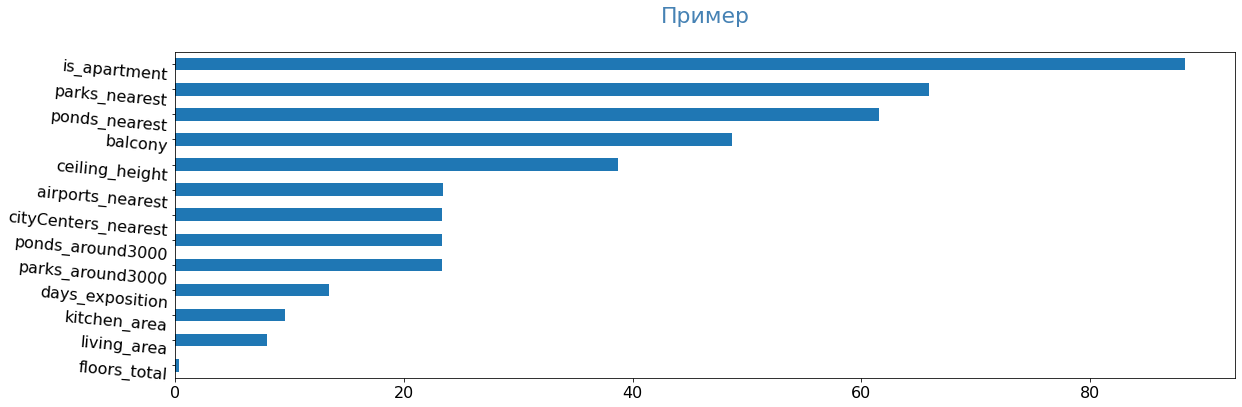

In [14]:
pass_value_barh(data)

In [15]:
data.isna().sum() #Проверка количества пропущенных значений:

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9163
floors_total               85
living_area              1898
floor                       0
is_apartment            20877
studio                      0
open_plan                   0
kitchen_area             2268
balcony                 11506
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15582
ponds_around3000         5510
ponds_nearest           14560
days_exposition          3178
dtype: int64

In [16]:
'''
Пропуски в количестве балконов заполняю нулями, т.к. наличие балкона важный параметр. 
Скорее всего владельцы квартир без балкона не заполнили данное поле в связи с отсутствием балкона.
'''
data['balcony'] = data['balcony'].fillna(0)
                                               
'''
Общая площадь есть у всех. Значит пропуски в площади кухни и жилую площадь заполним их разницей с общей площадью и балконом.
После этого остается 1460 строк, в которых И площадь кухни, И жилая площадь не заполнены изначально.
Для них заполняю медианой по группе по количеству комнат.
После этого остается 1787 строк, в которых data.query('total_area * 0.9 < (living_area + kitchen_area)')
С ними я не понимаю, что делать. Времени больше не остается на сборный проект. Отправляю так :(
Мне кажется это ошибки, вызванные: 
а) большим числом пропусков и , соответственно, их заполнением 
б) ошибки самих продавцов
Мне кажется это не окажет существенного влияние на предмет текущего исследования.
'''
data.loc[data['living_area'].isna(), 'living_area'] = data['total_area'] - data['kitchen_area'] - data['balcony']*3
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data['total_area'] - data['living_area'] - data['balcony']*3
data['kitchen_area'] = data.groupby('rooms')['kitchen_area'].apply(lambda x: x.fillna(x.median()))
data['living_area'] = data.groupby('rooms')['living_area'].apply(lambda x: x.fillna(x.median()))
#display(data.query('total_area * 0.9 < (living_area + kitchen_area)'))
data = data[data['kitchen_area'] > 3] #после заполнения разницами появились слишком маленькие значения. Отсеиваю
data = data[data['living_area'] > 8] #Минимальная площадь осталась 13 кв.м. Соответственно жилая площадь быть < 8 не может
'''
data.loc[data['living_area'].isna(), 'living_area'] = (
    data.loc[data['living_area'].isna(), 'total_area']
    - data.loc[data['living_area'].isna(), 'kitchen_area']
    - data.loc[data['living_area'].isna(), 'balcony']*3)
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = (
    data.loc[data['kitchen_area'].isna(), 'total_area']
    - data.loc[data['kitchen_area'].isna(), 'living_area']
    - data.loc[data['kitchen_area'].isna(), 'balcony']*3)
    '''  

data['ceiling_height'] = data.groupby('locality_name')['ceiling_height'].apply(lambda x: x.fillna(x.median()))
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())


'''
Пропуски в floors_total заполняю этажем квартиры + 1.
Какой конкретно этаж нам в данном исследовании значения не имеет, "последний" или "другой" значение есть.
Если заполнять медианой, то где-то floor > floors_total.
'''
data['floors_total'] = data['floors_total'].fillna(data['floor'] + 1) #

'''
Следующие параметры заполняем медианой по локациям
'''
data['airports_nearest'] = data.groupby('locality_name')['airports_nearest'].apply(lambda x: x.fillna(x.median()))
data['airports_nearest'] = data['airports_nearest'].fillna(data['airports_nearest'].median())

data['cityCenters_nearest'] = data.groupby('locality_name')['cityCenters_nearest'].apply(lambda x: x.fillna(x.median()))
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].median())

data['parks_around3000'] = data.groupby('locality_name')['parks_around3000'].apply(lambda x: x.fillna(x.median()))
data['parks_around3000'] = data['parks_around3000'].fillna(data['parks_around3000'].median())

data['parks_nearest'] = data.groupby('locality_name')['parks_nearest'].apply(lambda x: x.fillna(x.median()))
data['parks_nearest'] = data['parks_around3000'].fillna(data['parks_nearest'].median())

data['parks_nearest'] = data.groupby('locality_name')['parks_nearest'].apply(lambda x: x.fillna(x.median()))
data['parks_nearest'] = data['parks_nearest'].fillna(data['parks_nearest'].median())

data['ponds_around3000'] = data.groupby('locality_name')['ponds_around3000'].apply(lambda x: x.fillna(x.median()))
data['ponds_around3000'] = data['parks_around3000'].fillna(data['ponds_around3000'].median())

data['ponds_nearest'] = data.groupby('locality_name')['ponds_nearest'].apply(lambda x: x.fillna(x.median()))
data['ponds_nearest'] = data['ponds_nearest'].fillna(data['ponds_nearest'].median())

**Заметка:** 
1. За счет заполнения пропусков медианами, далее в гистограммах могут встречаться выделяющиеся медианным значением столбцы.
2. Осталось 23592 записи. Отсеяно < 5% датафрейма


#### Корректировка типов данных:

In [17]:
data['total_images'] = data['total_images'].astype('uint8') #меняем на беззнаковый меньшей разрядности для экономии битов
data['last_price'] = data['last_price'].astype('uint32') #меняем на беззнаковый меньшей разрядности для экономии битов
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y%m%dT') #меняем в дейттайм для возможности дальнейшего извлечения данных (день и т.д.)
data['rooms'] = data['rooms'].astype('uint8') #меняем на беззнаковый меньшей разрядности для экономии битов, комнаты нецелыми не бывают
data['floors_total'] = data['floors_total'].astype('uint8') #меняем на беззнаковый меньшей разрядности для экономии битов, этажность нецелыми не бывает
data['floor'] = data['floor'].astype('uint8') #меняем на беззнаковый меньшей разрядности для экономии битов
data['is_apartment'] = data['is_apartment'].astype('bool') #меняем на булевый так как соответствует значениям
data['studio'] = data['studio'].astype('bool') #меняем на булевый так как соответствует значениям
data['open_plan'] = data['open_plan'].astype('bool') #меняем на булевый так как соответствует значениям
data['kitchen_area'] = data['kitchen_area'].astype('float32')
data['balcony'] = data['balcony'].astype('uint8')
data['parks_around3000'] = data['parks_around3000'].astype('uint8') #меняем на беззнаковый меньшей разрядности для экономии битов
data['parks_nearest'] = data['parks_nearest'].astype('uint32') #меняем на беззнаковый меньшей разрядности для экономии битов
data['ponds_nearest'] = data['ponds_nearest'].astype('uint32') #меняем на беззнаковый меньшей разрядности для экономии битов
data['ponds_around3000'] = data['ponds_around3000'].astype('uint8') #меняем на беззнаковый меньшей разрядности для экономии битов
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype('uint32') #меняем на беззнаковый меньшей разрядности для экономии битов
data['airports_nearest'] = data['airports_nearest'].astype('uint32') #меняем на беззнаковый меньшей разрядности для экономии битов
try: #оборачиваю в try-except, т.к. есть пропуски
    data['days_exposition'] = data['days_exposition'].astype('uint16')
except:
    pass
data.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23563 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23563 non-null  uint8         
 1   last_price            23563 non-null  uint32        
 2   total_area            23563 non-null  float64       
 3   first_day_exposition  23563 non-null  datetime64[ns]
 4   rooms                 23563 non-null  uint8         
 5   ceiling_height        23563 non-null  float64       
 6   floors_total          23563 non-null  uint8         
 7   living_area           23563 non-null  float64       
 8   floor                 23563 non-null  uint8         
 9   is_apartment          23563 non-null  bool          
 10  studio                23563 non-null  bool          
 11  open_plan             23563 non-null  bool          
 12  kitchen_area          23563 non-null  float32       
 13  balcony         

**Вывод**: объем использованной памяти сократился на 2.8 Mb. Типы данных соответствуют значениям столбцов.

#### Корректировка наименования столбцов

In [18]:
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest_meters'}) #приводим к snake_case

In [19]:
# check
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,563.00","23,563.00","23,563.00","20,389.00","23,563.00","23,563.00","23,563.00","23,563.00","23,563.00"
min,1.00,13.00,2.51,1.00,"430,000.00",8.30,3.20,1.00,1.00
max,9.00,631.20,10.00,"1,580.00","330,000,000.00",571.00,227.00,32.00,33.00


In [20]:
# check
data.rooms.value_counts().to_frame()

,rooms
1,8168
2,7919
3,5795
4,1174
5,325
6,104
7,58
8,12
9,8


### Новые признаки:

Добавим в таблицу стоимость 1 метра, месяц публикации:

In [21]:
data['price/1m'] = round(data['last_price'] / data['total_area']) #добавляем столбец с ценой за 1 кв.м

def day(row): # день публикации 
    if row['first_day_exposition'].dayofweek == 0:
        return 'понедельник'
    elif row['first_day_exposition'].dayofweek == 1:
        return 'вторник'
    elif row['first_day_exposition'].dayofweek == 2:
        return 'среда'
    elif row['first_day_exposition'].dayofweek == 3:
        return 'четверг'
    elif row['first_day_exposition'].dayofweek == 4:
        return 'пятница'
    elif row['first_day_exposition'].dayofweek == 5:
        return 'суббота'
    elif row['first_day_exposition'].dayofweek == 6:
        return 'воскресенье'
data['day_exposition'] = data.apply(day, axis=1)

def month(row): # добавляем столбец месяц публикации 
    if row['first_day_exposition'].month == 1:
        return 'январь'
    elif row['first_day_exposition'].month == 2:
        return 'февраль'
    elif row['first_day_exposition'].month == 3:
        return 'март'
    elif row['first_day_exposition'].month == 4:
        return 'апрель'
    elif row['first_day_exposition'].month == 5:
        return 'май'
    elif row['first_day_exposition'].month == 6:
        return 'июнь'
    elif row['first_day_exposition'].month == 7:
        return 'июль'
    elif row['first_day_exposition'].month == 8:
        return 'август'
    elif row['first_day_exposition'].month == 9:
        return 'сентябрь'
    elif row['first_day_exposition'].month == 10:
        return 'октябрь'
    elif row['first_day_exposition'].month == 11:
        return 'ноябрь'
    elif row['first_day_exposition'].month == 12:
        return 'декабрь'
data['month_exposition'] = data.apply(month, axis=1)

def year(row): # добавляем столбец год публикации 
    return row['first_day_exposition'].year
data['year_exposition'] = data.apply(year, axis=1)

def floor_type(row): # добавляем столбец тип этажа квартиры (значения — «первый», «последний», «другой»);
    if row['floor'] == 0:
        return 'цокольный'
    elif row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['type_floor'] = data.apply(floor_type, axis=1)

data['city_centers_nearest_km'] = data['city_centers_nearest_meters'] / 1000 #добавлям столбец с расстоянием в метрах

In [22]:
# check
data['city_centers_nearest_km'].head(2)

0    16.028
1    18.603
Name: city_centers_nearest_km, dtype: float64

## Исследовательский анализ данных

### Изучим параметры объектов

In [23]:
def review(df, col): #функция для обзора данных
    desc = df[col].describe()
    hst = df[col].hist(bins=80, range=(desc[3], desc[6]*2), figsize=(15,8))
    plt.title(col + ' hist')
    plt.xlabel(col)
    hst.set_xlabel(col)
    hst.set_ylabel('quantity')
    plt.show()
    
    df.boxplot(column=col, vert = False, figsize=(15,4)).set_title('Диаграмма размаха значений')
    plt.ylim(0, 2)
    plt.xlim(0,desc[6]*2)
    plt.show()
    #print(desc)
    print('Медиана:',df[col].median())
    print(f'50% наблдюдений (межквартильный размах) находятся в диапазоне между {round(desc[4], 1)} и {round(desc[6], 1)}')
    m = desc[3]
    poltora_q1 = desc[4] - 1.5*(desc[6] - desc[4])
    if poltora_q1 < 0:
        print(f'Нормальный диапазон значений: c {desc[3]} до {desc[6] + 1.5*(desc[6] - desc[4])}' )
    else:
        print(f'Нормальный диапазон значений: c {desc[4] - 1.5*(desc[6] - desc[4])} до {desc[6] + 1.5*(desc[6] - desc[4])}' )
    

**Заметка:** Далее описание будет в ячейках с кодом

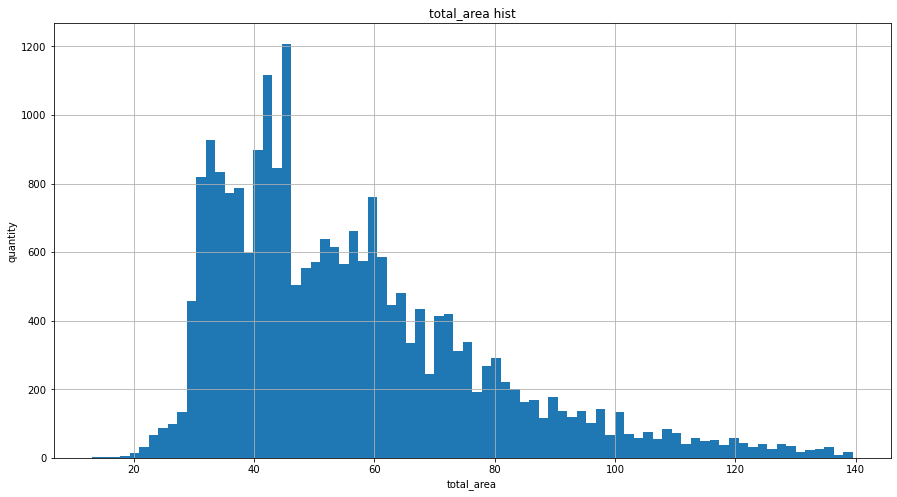

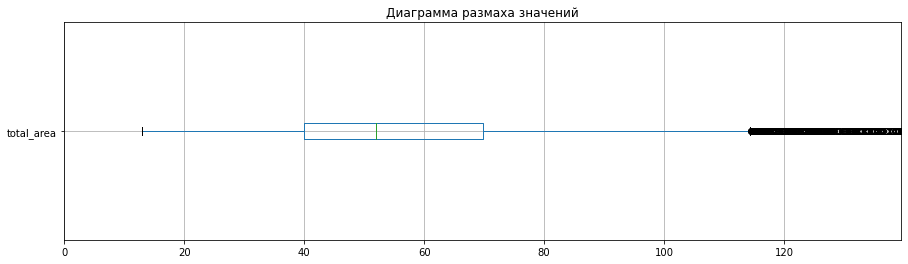

Медиана: 52.0
50% наблдюдений (межквартильный размах) находятся в диапазоне между 40.0 и 69.7
Нормальный диапазон значений: c 13.0 до 114.36250000000001


In [24]:
review(data, 'total_area')

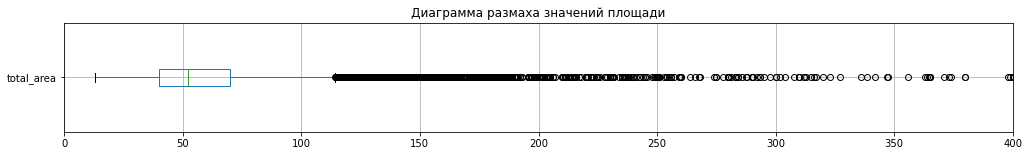

In [25]:
# check
# для примера горизонтальный вид диаграммы размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = data[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 400);

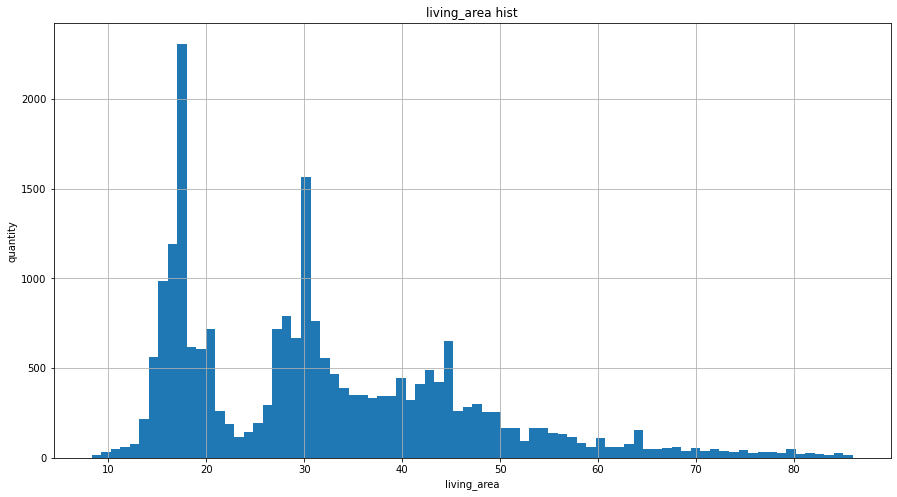

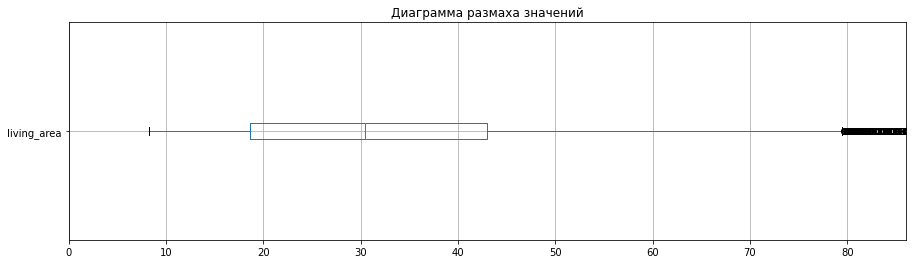

Медиана: 30.450000000000003
50% наблдюдений (межквартильный размах) находятся в диапазоне между 18.6 и 43.0
Нормальный диапазон значений: c 8.3 до 79.6


In [26]:
review(data, 'living_area')

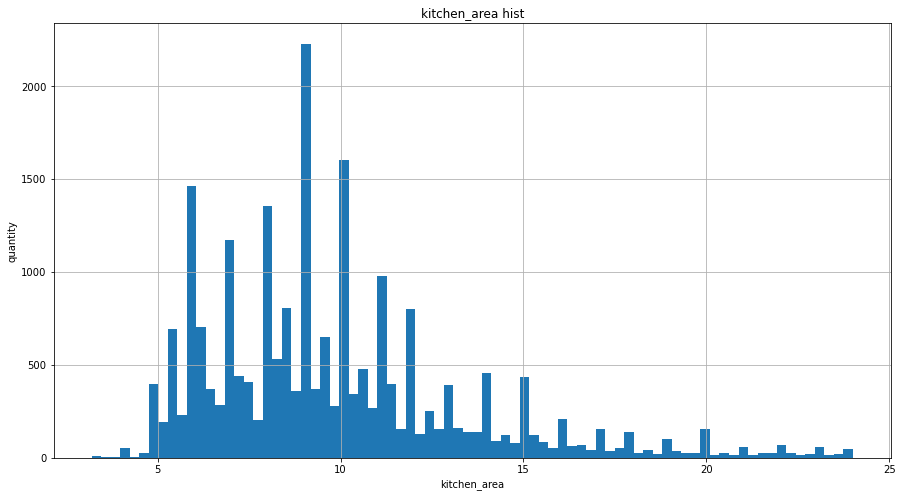

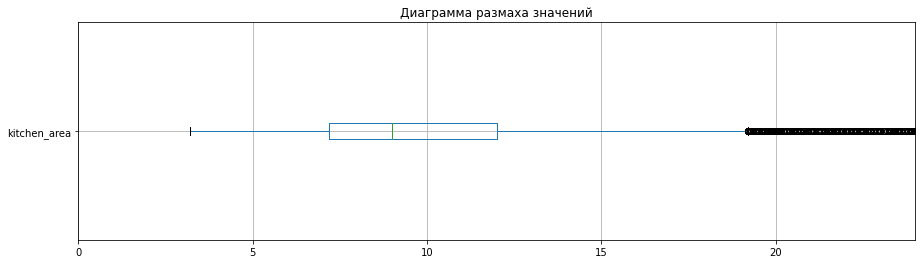

Медиана: 9.0
50% наблдюдений (межквартильный размах) находятся в диапазоне между 7.2 и 12.0
Нормальный диапазон значений: c 3.200000047683716 до 19.200000286102295


In [27]:
review(data, 'kitchen_area')

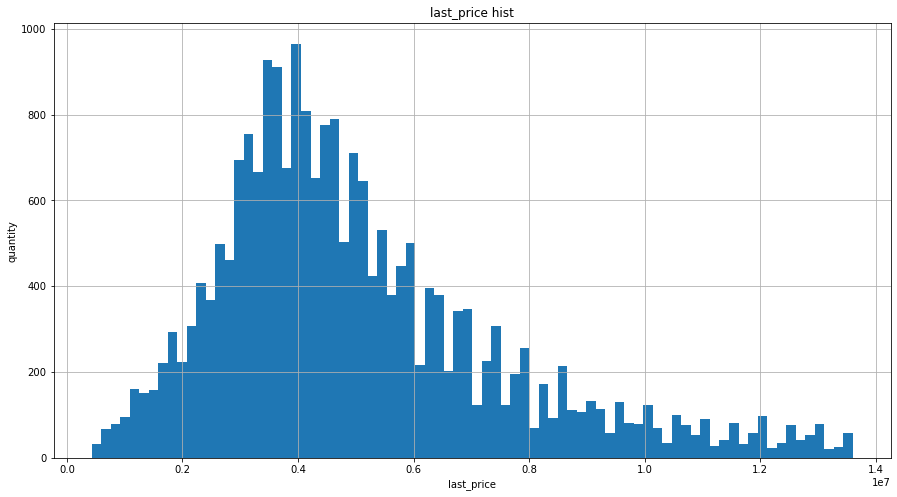

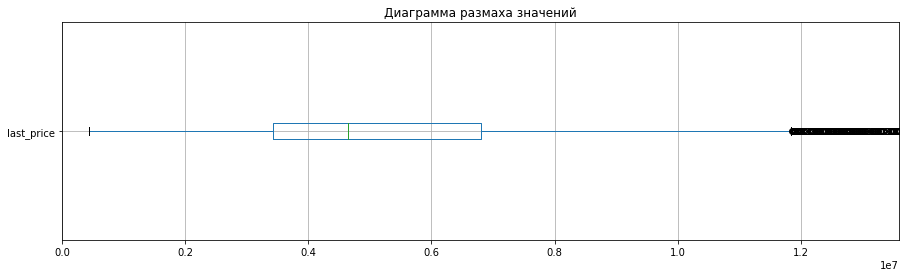

Медиана: 4650000.0
50% наблдюдений (межквартильный размах) находятся в диапазоне между 3430000.0 и 6800000.0
Нормальный диапазон значений: c 430000.0 до 11855000.0


In [28]:
review(data, 'last_price')

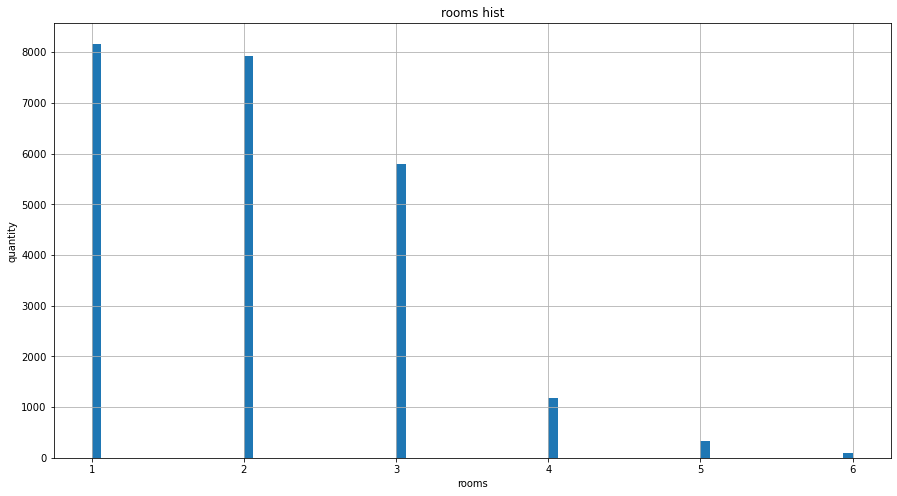

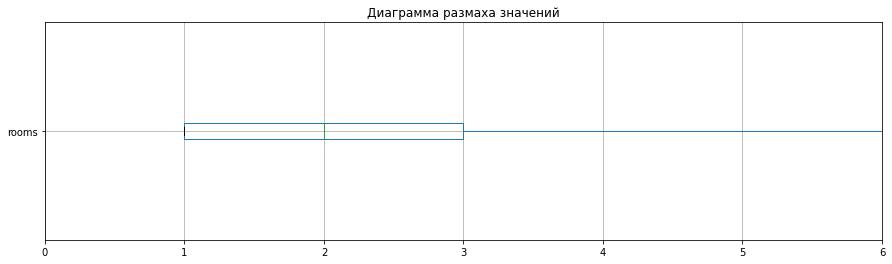

Медиана: 2.0
50% наблдюдений (межквартильный размах) находятся в диапазоне между 1.0 и 3.0
Нормальный диапазон значений: c 1.0 до 6.0


In [29]:
review(data, 'rooms')

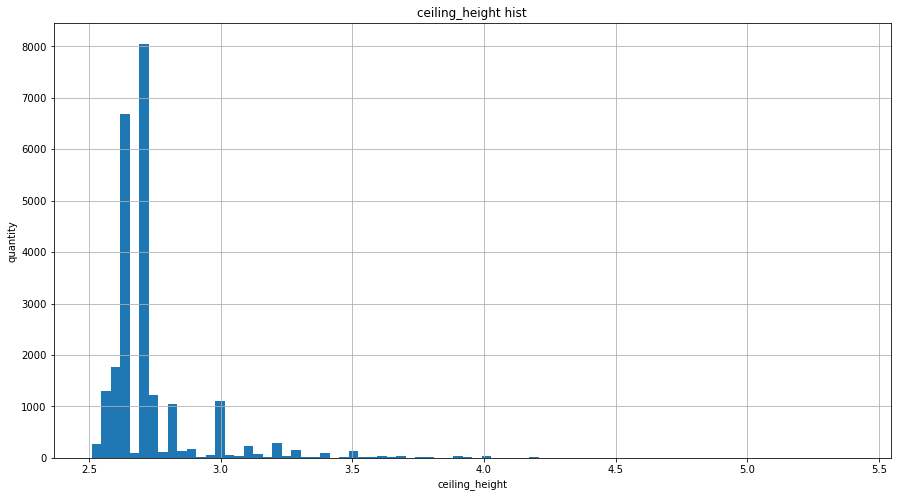

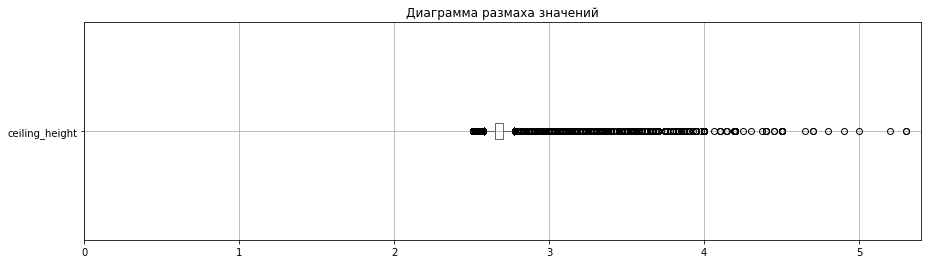

Медиана: 2.7
50% наблдюдений (межквартильный размах) находятся в диапазоне между 2.6 и 2.7
Нормальный диапазон значений: c 2.5749999999999993 до 2.7750000000000004


In [30]:
review(data, 'ceiling_height')

Процент "других" этажей:  0.736
Процент "первых" этажей:  0.123
Процент "последних" этажей:  0.141


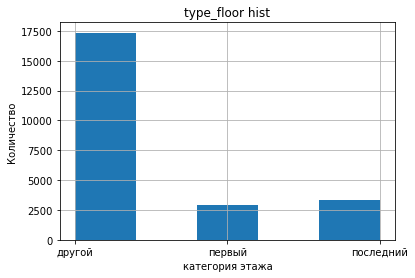

In [31]:
data['type_floor'].hist(bins=5)
plt.title('type_floor hist')
plt.xlabel('категория этажа')
plt.ylabel('Количество')

other = data.loc[data['type_floor'] == 'другой', 'type_floor'].count() / data['type_floor'].count()
first = data.loc[data['type_floor'] == 'первый', 'type_floor'].count() / data['type_floor'].count()
last = data.loc[data['type_floor'] == 'последний', 'type_floor'].count() / data['type_floor'].count()
print('Процент "других" этажей: ', round(other, 3))
print('Процент "первых" этажей: ', round(first, 3))
print('Процент "последних" этажей: ', round(last,3))

**Вывод:** Подавляющая часть недвижимости (73.6%) находится между первым и последним этажами. Доля первых и последних примерно равная: 12.3% и 14.1% соответственно.

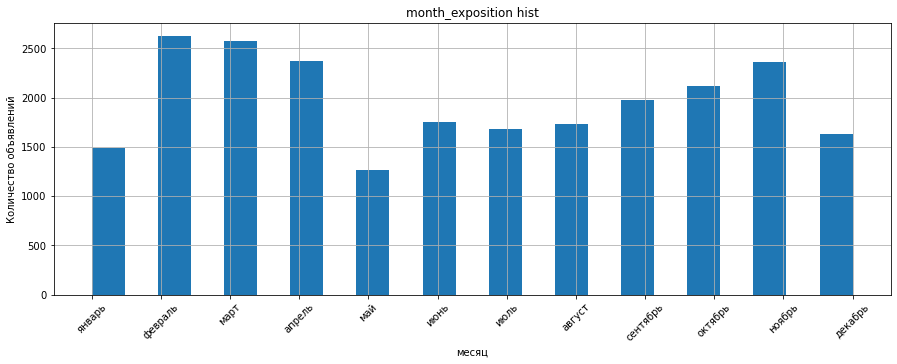

In [32]:
cats = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август','сентябрь', 'октябрь', 'ноябрь', 'декабрь']
data['month_exposition'] = pd.Categorical(data['month_exposition'], categories=cats, ordered=True)
data['month_exposition'].sort_values().hist(bins=23, xrot=45, figsize=(15, 5))
plt.title('month_exposition hist')
plt.xlabel('месяц')
plt.ylabel('Количество объявлений')
plt.show()

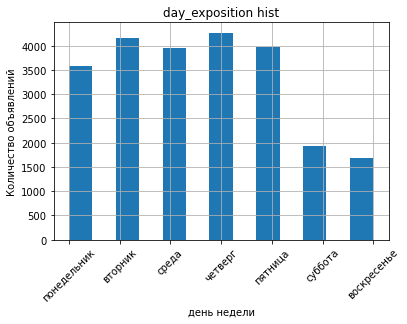

In [33]:
cats = ['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье']
data['day_exposition'] = pd.Categorical(data['day_exposition'], categories=cats, ordered=True)
data['day_exposition'].sort_values().hist(bins=13, xrot=45)
plt.title('day_exposition hist')
plt.xlabel('день недели')
plt.ylabel('Количество объявлений')
plt.show()

**Вывод:** В любой из будних дней в продажу выкладывается квартир больше, чем в выходные дни. В выходные количество примерно одинаковое, разница между будними днями также незначительная. Наибольшая активность продавцов - во вторник и четверг - после "тяжелого понедельника" и перед выходными.

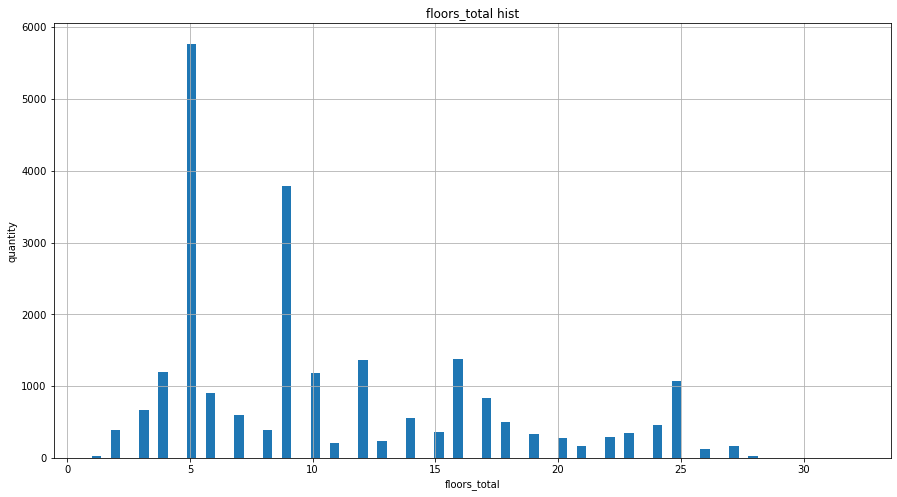

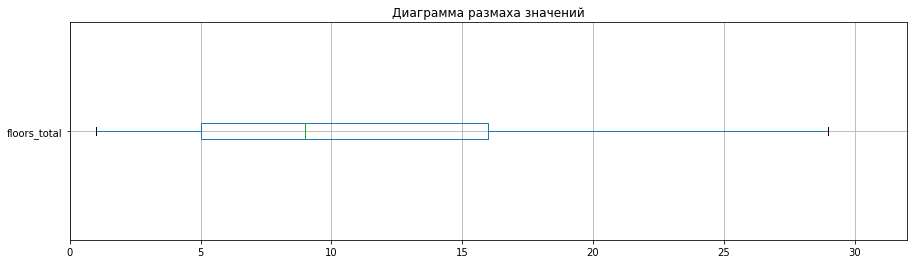

Медиана: 9.0
50% наблдюдений (межквартильный размах) находятся в диапазоне между 5.0 и 16.0
Нормальный диапазон значений: c 1.0 до 32.5


In [34]:
review(data, 'floors_total')

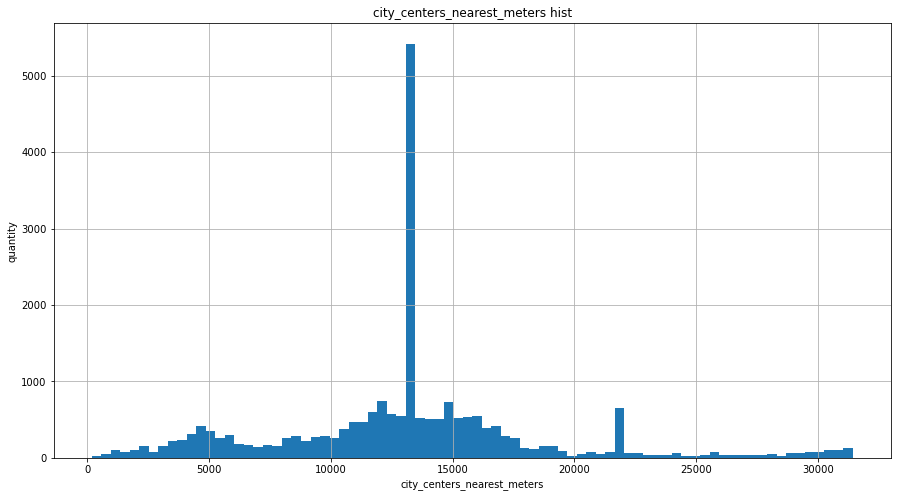

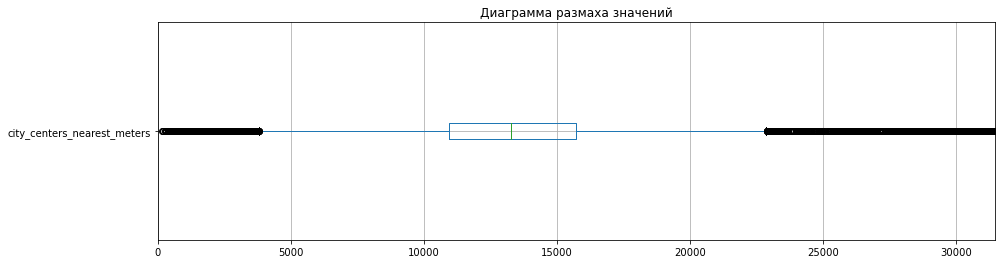

Медиана: 13266.0
50% наблдюдений (межквартильный размах) находятся в диапазоне между 10948.5 и 15717.5
Нормальный диапазон значений: c 3795.0 до 22871.0


In [35]:
review(data, 'city_centers_nearest_meters')

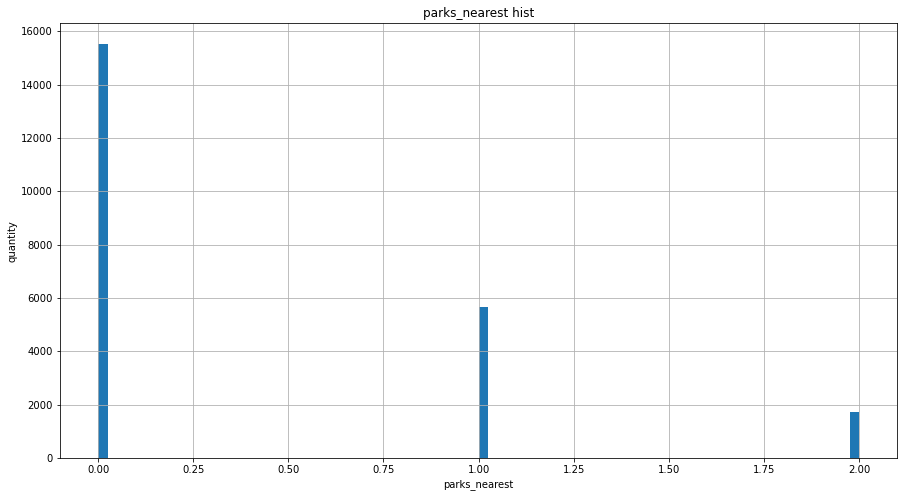

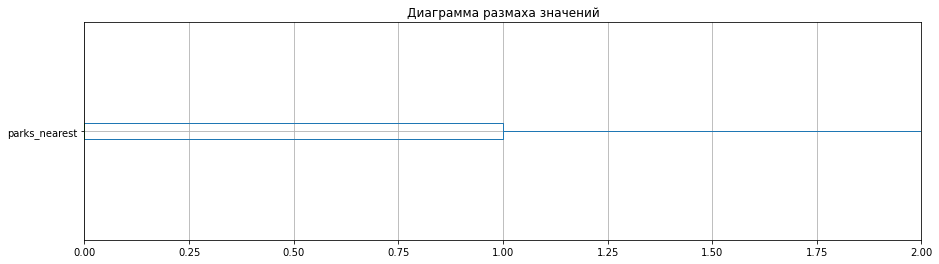

Медиана: 0.0
50% наблдюдений (межквартильный размах) находятся в диапазоне между 0.0 и 1.0
Нормальный диапазон значений: c 0.0 до 2.5


In [36]:
review(data, 'parks_nearest')

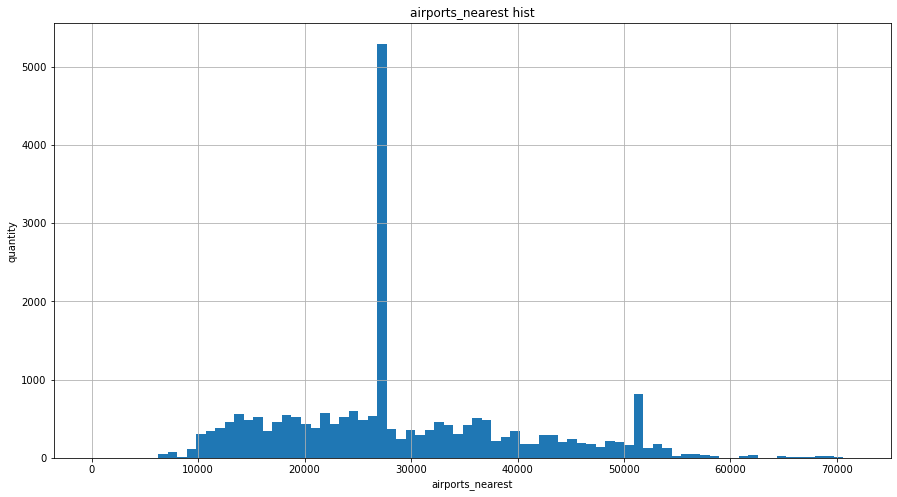

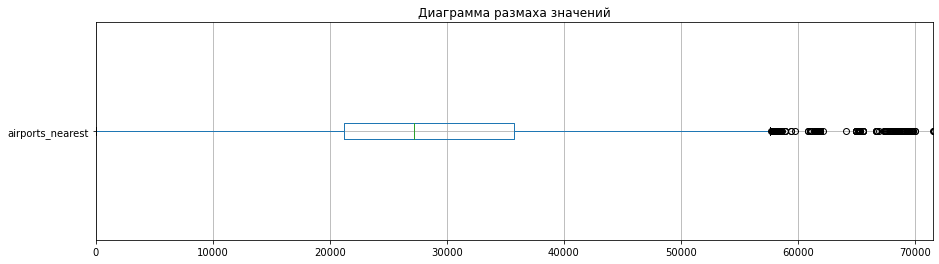

Медиана: 27179.0
50% наблдюдений (межквартильный размах) находятся в диапазоне между 21177.0 и 35742.0
Нормальный диапазон значений: c 0.0 до 57589.5


In [37]:
review(data, 'airports_nearest')

### Оценка скорости продажи квартир

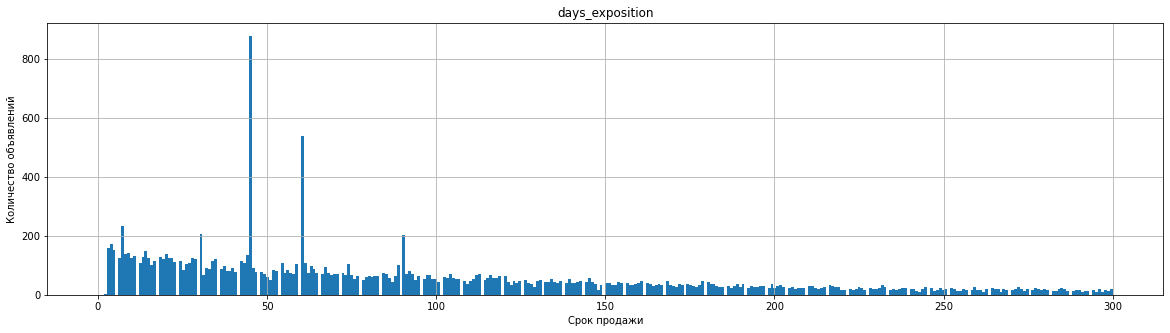

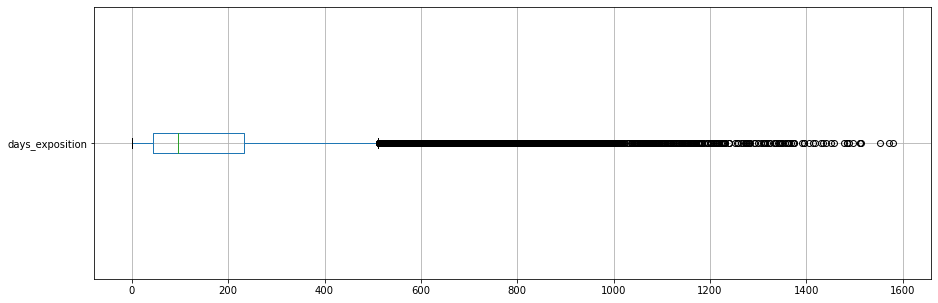

Медиана:     95.0
count    20389.000000
mean       180.906126
std        219.748161
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


0    45.0
Name: days_exposition, dtype: float64

In [38]:
data['days_exposition'].hist(bins=350, range=(0, 300), figsize=(20, 5))
plt.title('days_exposition')
plt.xlabel('Срок продажи')
plt.ylabel('Количество объявлений')

plt.show()
data.boxplot(column='days_exposition', vert = False, figsize=(15,5))
plt.ylim(0, 2)
#plt.xlim(0, 600)
plt.show()
print('Медиана:    ',data['days_exposition'].median())
print(data['days_exposition'].describe())

data['days_exposition'].mode()

**Вывод:** 
1. В среднем срок продажи квартиры составляет 181 день, однако медиана - 95 дней. Встречаются и продажи на 1-й и 1580-й (максиум) дни. Нормальной можно считать продажу от 45 до 232 дней (1 и 3 квартили). Необычайно долгие продажи длятся от 500 дней (1.5 межквартильных размаха)
2. На графике четко заметны выделяющиеся значения срок продажи: 45, 60, 90. Эти значения соответствуют срокам размещения объявлений на Площадке в зависимости от стоимости недвижимости. Мода - 45, что означает самый частый срок размещения для недвижимости ценой до 4.5 млн.руб.это именно 45 дней, после чего объявление уходит из выдачи. Владельцы недвижимости в этой категории реже других продлевают срок размещения.

### Факторы, влияющие на стоимость квартиры

In [39]:
data = data.query('last_price < 30000000') #отсеял для наглядности графика.
data = data.query('total_area < 200') #отсеял для наглядности графика.
data = data.query('living_area < 180') #отсеял для наглядности графика.
data = data.query('kitchen_area < 50') #отсеял для наглядности графика.

Коэффициент корреляции стоимости жилья от его площади, %:  78.4


Text(0, 0.5, 'Стоимость квартиры')

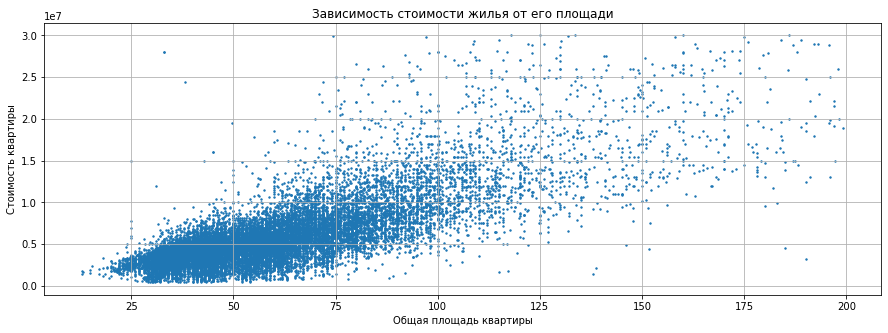

In [40]:
k1 = data['last_price'].corr(data['total_area'])*100
print('Коэффициент корреляции стоимости жилья от его площади, %: ', round(k1,1))
data.plot.scatter(x='total_area', y='last_price', figsize=(15,5), grid=True, s=2);
plt.title('Зависимость стоимости жилья от его площади')
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Стоимость квартиры')

Коэффициент корреляции стоимости жилья от его жилой площади, %:  65.5


Text(0, 0.5, 'Стоимость квартиры')

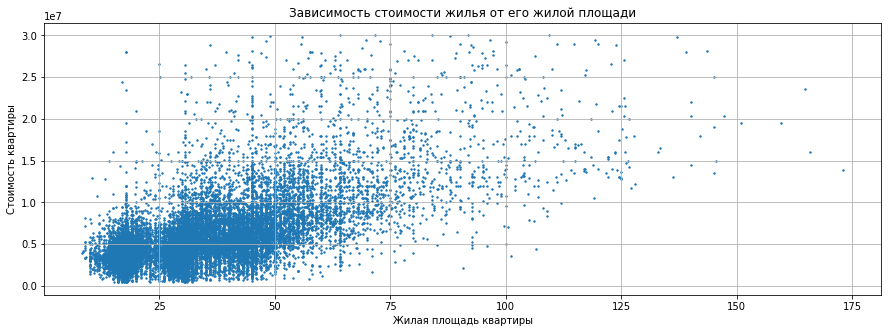

In [41]:
k2 = data['last_price'].corr(data['living_area'])*100
print('Коэффициент корреляции стоимости жилья от его жилой площади, %: ', round(k2, 1))
data.plot.scatter(x='living_area', y='last_price', figsize=(15,5), grid=True, s=2);
plt.title('Зависимость стоимости жилья от его жилой площади')
plt.xlabel('Жилая площадь квартиры')
plt.ylabel('Стоимость квартиры')

Коэффициент корреляции стоимости жилья от площади кухни, %:  54.2


Text(0, 0.5, 'Стоимость квартиры')

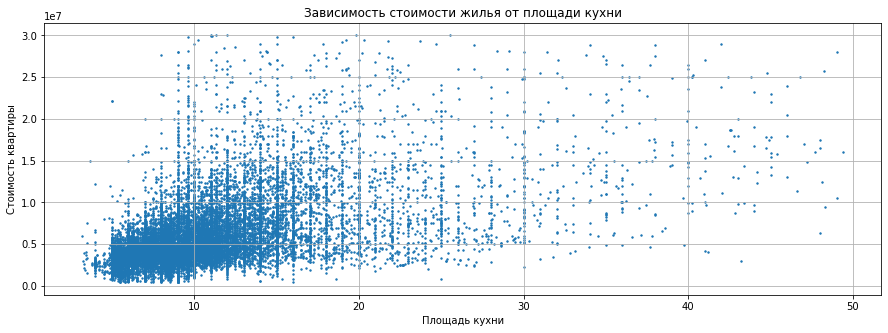

In [42]:
k3 = data['last_price'].corr(data['kitchen_area'])*100
print('Коэффициент корреляции стоимости жилья от площади кухни, %: ', round(k3, 1))
data.plot.scatter(x='kitchen_area', y='last_price', figsize=(15,5), grid=True, s=2);
plt.title('Зависимость стоимости жилья от площади кухни')
plt.xlabel('Площадь кухни')
plt.ylabel('Стоимость квартиры')

Text(0, 0.5, 'Стоимость квартиры')

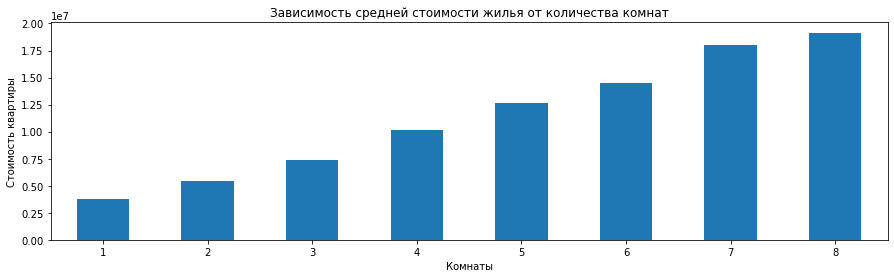

In [43]:
price_rooms = data.pivot_table(index='rooms', values='last_price', aggfunc='mean')
price_rooms.plot(kind='bar', figsize=(15, 4), rot=0, legend=False);
plt.title('Зависимость средней стоимости жилья от количества комнат')
plt.xlabel('Комнаты')
plt.ylabel('Стоимость квартиры')


Text(0, 0.5, 'Стоимость квартиры')

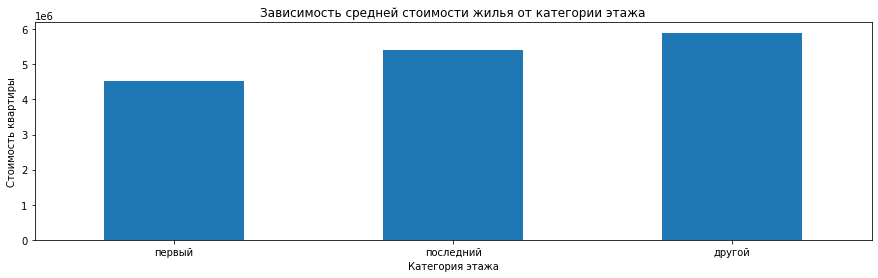

In [44]:
price_type_floor = data.pivot_table(index='type_floor', values='last_price', aggfunc='mean').sort_values(by='last_price')
price_type_floor.plot(kind='bar', figsize=(15, 4), rot=0, legend=False);
plt.title('Зависимость средней стоимости жилья от категории этажа')
plt.xlabel('Категория этажа')
plt.ylabel('Стоимость квартиры')

Text(0, 0.5, 'Стоимость квартиры')

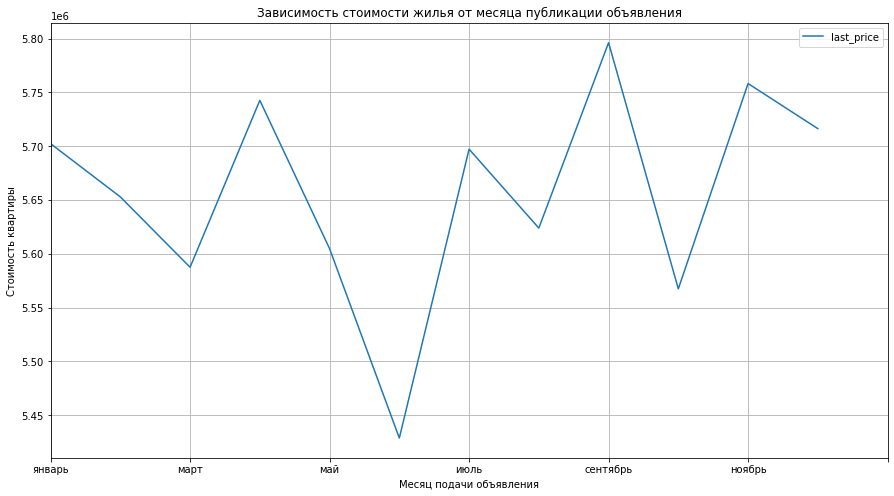

In [45]:
price_month = data.pivot_table(index='month_exposition', values='last_price', aggfunc='mean').sort_values(by='month_exposition')

price_month.plot(figsize=(15, 8), grid=True)
plt.xlim(0, 12)

plt.title('Зависимость стоимости жилья от месяца публикации объявления')
plt.xlabel('Месяц подачи объявления')
plt.ylabel('Стоимость квартиры')

Text(0, 0.5, 'Стоимость квартиры')

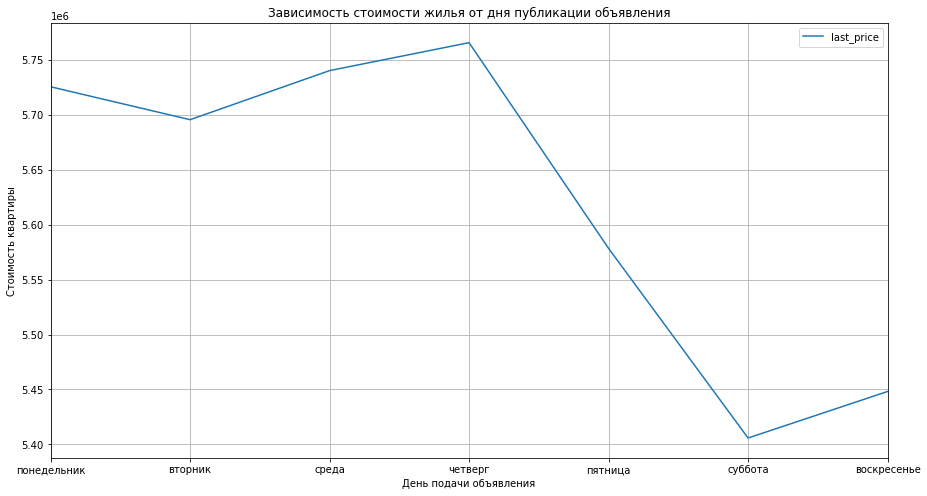

In [46]:
price_day = data.pivot_table(index='day_exposition', values='last_price', aggfunc='mean').sort_values(by='day_exposition')

price_day.plot(figsize=(15, 8), grid=True)
plt.xlim(0, 6)

plt.title('Зависимость стоимости жилья от дня публикации объявления')
plt.xlabel('День подачи объявления')
plt.ylabel('Стоимость квартиры')

Text(0, 0.5, 'Стоимость квартиры')

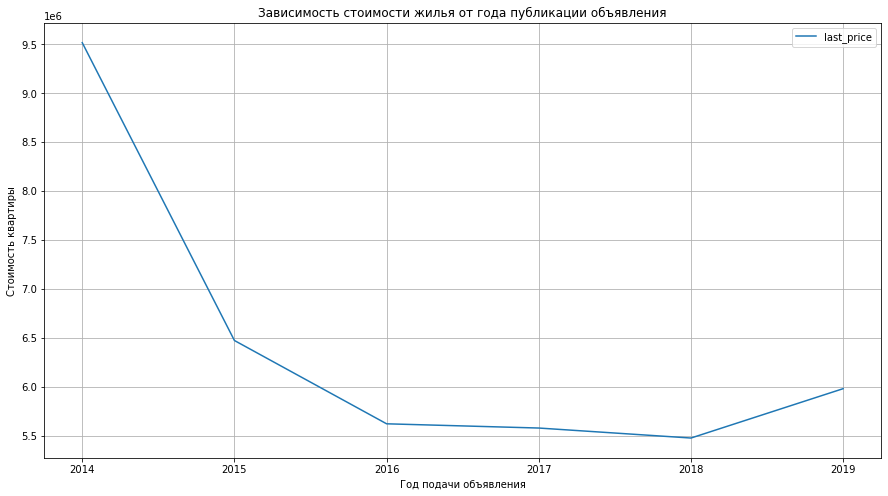

In [47]:
price_year = data.pivot_table(index='year_exposition', values='last_price', aggfunc='mean').sort_values(by='year_exposition')

price_year.plot(figsize=(15, 8), grid=True)

plt.title('Зависимость стоимости жилья от года публикации объявления')
plt.xlabel('Год подачи объявления')
plt.ylabel('Стоимость квартиры')

**Вывод:** Рассмотрели влияние следующих параметров на стоимость жилья: общая площадь, жилая и кухонная площади, этаж, а также день подачи объявления:
1. Большая корреляция цены отмечена у общей и жилой площади. Коэффициенты корреляции для этих параметров имеют значения 0.71 и 0.61, что говорит достаточно линейной зависимости, хоть и не важдом случае.
2. Площадь кухни также имеет положительный коэффициент корреляции, однако он составялет всего 0.48. Площадь кухни напрямую зависит от общей площади квартиры, которая в свою очередь оказывает ключевое влияние на стоимость. 
4. Корреляция стоимости квартиры с количеством комнат и того меньше: 0.40. Зависимость определенно есть, т.к. количество комнат чаще всего положительно влияет на общую площадь, но это явно не определяющий фактор.
3. Средняя стоимость квартиры на первом этаже ниже стоимости квартиры на последнем на 11.5% и ниже стоимости на 24.5% ниже, чем на этаже между первым и последнем.

#### Средняя цена кв.м в населенных пунктах с наибольшим числом объявлений

In [48]:
max_n = data.groupby('locality_name').agg({'rooms': 'count', 'price/1m': 'mean'}).sort_values(by='rooms', ascending=False)
max_n.columns = ['count', 'price/1m']
print(max_n['count'].head(10).sum() / len(data))
display(max_n.round().astype('int').head(10))
#display(max_n[max_n['price/1m'] == max_n['price/1m'].min()])

0.7991955713173601


,count,price/1m
locality_name,,
город санкт-петербург,15237,110525
поселок мурино,543,85386
поселок шушары,439,78520
город всеволожск,397,68647
город пушкин,359,102910
город колпино,337,75333
поселок парголово,326,90332
город гатчина,307,68746
деревня кудрово,297,92456


**Вывод:** Локации с наибольшим числом объявлений о продаже показаны выше: это Санкт-Петербург и его пригороды. На них приходится 80% выборки. Максимальная средняя стоимость квадратного метра жилья - в Санкт-Петербурге. Она составялет 114789 рублей / 1 кв.м площади. Минимальная цена среди топовой по числу объявлений десятки - в Выборге: 58142 рубля / 1 кв.м. площади. 

#### Влияние близости к центру города в Санкт-Петербурге на стоимость 1 кв.м.

Text(0, 0.5, 'Стоимость 1 кв.м')

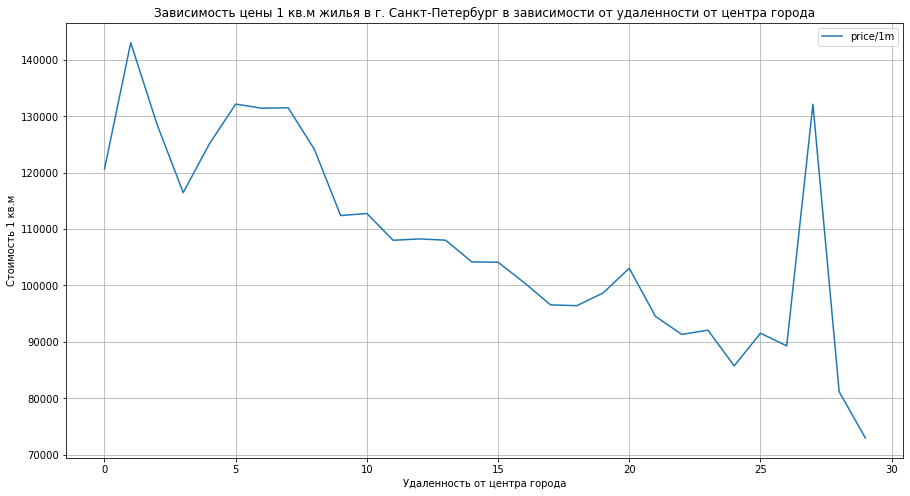

In [49]:
data['city_centers_nearest_km'] = data['city_centers_nearest_km'].apply(lambda x: round(x, 0))
data['city_centers_nearest_km'] = data['city_centers_nearest_km'].astype('int')

spb_price_km_gr = (
    data[data['locality_name'] == 'город санкт-петербург']
    .pivot_table(index='city_centers_nearest_km', values='price/1m', aggfunc='mean')
    .sort_values(by='city_centers_nearest_km'))

spb_price_km_gr.plot(figsize=(15, 8), grid=True)
plt.title('Зависимость цены 1 кв.м жилья в г. Санкт-Петербург в зависимости от удаленности от центра города')
plt.xlabel('Удаленность от центра города')
plt.ylabel('Стоимость 1 кв.м')

**Вывод:** 
1. Зависимость цены 1 кв.м жилья в г. Санкт-Петербург в зависимости от удаленности от центра города значительная.
2. На расстоянии с 3 до 6 км от центра города заметно значительное повышение средней стоимости. Вероятно на среднюю цену влияет элитная недвижимость на Крестовском острове и близлежащих территориях (оценил по яндекс.картам)
3. На 27-м километре заметен всплеск стоимости, вероятно он вызван ошибкой при указании локации: радиус Санкт-Петербурга от дворцовой площади до его разумных границ заканчивается на примерно 15 км. На удаленности 27 км находятся дорогостоящие по сравнению со спальными районами пригороды: Петергоф, Ломоносов, Павловск.

### Общий вывод

В ходе исследования выполнена предобработка и анализ датасета недвижимости Санкт-Петербурга и Ленингадской области. Влияние ряда факторов на стоимость квадратного метра стало целью исследования. 

Наибольшее влияние на цену оказывают:
1. Общая и жилая площади. Их проценты корреляции составляют 0.71 и 0.61 соответственно, что говорит достаточно большой линейной зависимости.
2. Количество комнат
3. Расстояние до центра города
4. Статус района
5. Этаж. Покупателей отталкивают квартиры, расположенные на первом и последнем этажах. В среднем такие квартиры потеряют 24% и 11.5% стоимости по отношению к квартирам, расположенным между первым и последним.
6. Год публикации. С 2014 по 2018 год средняя цена квартиры упала с 9.5 до 5.5 млн.рублей. Снижение вероятно связано с международными санкциями, падением курса рубля
7. Месяц публикации объявления. Наблюдается минимум средней стоимости в июне, максимум - в сентябре.
8. Стоимость квартиры возрастает по неизвестным причинам при публикации с понедельника по четверг, и падает в пятницу-воскресенье.


В среднем срок продажи квартиры составляет 181 день при медиане в 96 дней. Нормальной можно считать продажу в пределах между 45 и 232 днями. Необычайно долгие продажи длятся от 500 дней (1.5 межквартильных размаха).

В выходной день количество объявлений в среднем в 2 раза меньше, чем в любой будний.

На топ-10 лидеров по количеству предложений приходится 80% квартир. В этот список входят:
1. Санкт-Петерубрг со средней ценой 114788 рублей за 1 кв.м
2. Мурино со средней ценой 85000 рублей за 1 кв.м
3. Шушары со средней ценой 78405 рублей за 1 кв.м
4. Всеволожск со средней ценой 68618 рублей за 1 кв.м
5. Пушкин со средней ценой 103125 рублей за 1 кв.м
6. Колпино со средней ценой 75424 рубля за 1 кв.м
7. Парголово со средней ценой 90289 рублей за 1 кв.м
8. Гатчина со средней ценой 68746 рублей за 1 кв.м
9. Кудрово со средней ценой 92297 рублей за 1 кв.м
10. Выборг со средней ценой 58141 рублей за 1 кв.м


Среднестатичтическая квартира характеризуется следующими медианными значениями:
* Общая площадь: 52 кв.м
* Жилая площадь: 30.6 кв.м.
* Площадь кухни: 9.0 кв.м
* Стоимость: 4 650 000 рублей
* Количество комнат: 2
* Высота потолков: 2.7 м.
* Расположена в 5 или 9 этажном доме
* Расположение: 13.2 км до центра города
* Количество парков в радиусе 3 км: 0
* Расстояние до ближайшего аэропорта: 27.1 км